# Twitter Ngram time series and anomaly detection with isolation forest

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle
import re
import nltk  
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import plotly.express as px

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucadg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('Database/twcs.csv')

In [3]:
df.rename(columns={'created_at': 'Date', 'text': 'Tweet'}, inplace=True)

In [4]:
df['Date']  = pd.to_datetime(df['Date'], format='%a %b %d %H:%M:%S +0000 %Y')
df['Date'] = df['Date'].dt.date

In [5]:
df = df[df['Tweet'].str.contains('amazon', case=False)]

In [6]:
print(len(df))

163887


In [7]:
df.head(10)

,tweet_id,author_id,inbound,Date,Tweet,response_tweet_id,in_response_to_tweet_id
182,270,115770,True,2017-11-22,@AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。,NaN,269.0
183,271,115770,True,2017-11-22,@AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎ...,273,269.0
185,274,115770,True,2017-11-22,@AmazonHelp こちらこそありがとうございました。,275,273.0
187,272,115770,True,2017-11-22,amazonのfireTVstickが見れない😢,269,NaN
235,325,115792,True,2017-11-22,amazonプライムビデオ、再生エラーが多いです,324,NaN
311,605,115814,True,2017-10-31,whats wrong w/ amazon leavin shit outside like...,604,NaN
322,616,115820,True,2017-10-31,@AmazonHelp 3 different people have given 3 di...,618,615.0
324,619,115820,True,2017-10-31,@AmazonHelp I frankly don't have the patience ...,NaN,618.0
327,621,115822,True,2017-10-31,@115823 I want my amazon payments account CLOS...,620,NaN
329,623,115824,True,2017-10-31,"@AmazonHelp Okay, danke für die Info",625,622.0


In [8]:
df=df[df['inbound'] == True]

In [9]:
def rimuovi_menzioni_hashtag(testo):
    testo_pulito = re.sub(r'\s*[@#]\w+\s*', ' ', testo)
    return testo_pulito


In [10]:
df['Tweet'] = df['Tweet'].apply(rimuovi_menzioni_hashtag)

In [11]:
df.head(10)

,tweet_id,author_id,inbound,Date,Tweet,response_tweet_id,in_response_to_tweet_id
182,270,115770,True,2017-11-22,ありがとうございます。\n今、電話で主人が対応していただいてます。,NaN,269.0
183,271,115770,True,2017-11-22,電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎてるので買い直しになる...,273,269.0
185,274,115770,True,2017-11-22,こちらこそありがとうございました。,275,273.0
187,272,115770,True,2017-11-22,amazonのfireTVstickが見れない😢,269,NaN
235,325,115792,True,2017-11-22,amazonプライムビデオ、再生エラーが多いです,324,NaN
311,605,115814,True,2017-10-31,whats wrong w/ amazon leavin shit outside like...,604,NaN
322,616,115820,True,2017-10-31,3 different people have given 3 different ans...,618,615.0
324,619,115820,True,2017-10-31,I frankly don't have the patience for another...,NaN,618.0
327,621,115822,True,2017-10-31,I want my amazon payments account CLOSED. dm...,620,NaN
329,623,115824,True,2017-10-31,"Okay, danke für die Info",625,622.0


# Clean Dataset remove stop words 

In [12]:
def clean_dataset(df):

    # Convert the 'Tweet' column to lowercase
    df['Tweet'] = df['Tweet'].str.lower()
    # Remove punctuation
    symbols = ",!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        df['Tweet'] = df['Tweet'].str.replace(i, ' ', regex=False)
    # Remove single quotes
    df['Tweet'] = df['Tweet'].str.replace("'", ' ', regex=False)
    # Remove rows where 'Tweet' is null
    df = df[df['Tweet'].notna()]
    # Remove digits
    df['Tweet'] = df['Tweet'].str.replace('\d+', '', regex=False)
    # Remove numbers
    df["Tweet"] = df["Tweet"].apply(lambda x: ' '.join([i for i in x.split() if not i.isdigit()]))
    
    return df

In [13]:
def rimuovistopwords(df):
        StSpa=stopwords.words('spanish')
        StIta=stopwords.words('italian')
        StEn=stopwords.words('English')
        StPers=['http','https','rt','posted','customer','support','help']
       

        final_list=StIta+StSpa+StEn+StPers
  
   
        df["Tweet"]=df["Tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_list)]))        

        return df

In [14]:
def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    df['Lemmatized_text'] = df['Tweet'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]))
    return df

In [15]:
cdf=clean_dataset(df)

In [16]:
rcdf=rimuovistopwords(cdf)

In [17]:
lcdf=lemmatize(rcdf)

# Generate NGram

In [18]:
def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=20000):

        vec = CountVectorizer(ngram_range = (ngram_from, ngram_to), 
                              max_features = max_features, 
                              stop_words='english').fit(text)
        bag_of_words = vec.transform(text)
        sum_words = bag_of_words.sum(axis = 0) 
        words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

        return words_freq[:n]

In [19]:
unigrams=get_ngrams(lcdf['Lemmatized_text'], ngram_from=1, ngram_to=1, n=2000)

In [20]:
 DfUniGramsAC = pd.DataFrame(unigrams,columns =['Word','Frequency'])

In [21]:
bigrams=get_ngrams(lcdf['Lemmatized_text'], ngram_from=2, ngram_to=2, n=2000)

In [22]:
 Df2GramsAC = pd.DataFrame(bigrams,columns =['Word','Frequency'])

In [23]:
DfUniGramsAC.head(100) 
Df2GramsAC.head(100) 

,Word,Frequency
0,amazon prime,2713
1,day delivery,1621
2,delivery date,1267
3,day shipping,1031
4,amazon pay,877
...,...,...
95,amazon music,240
96,social medium,239
97,ordered amazon,239
98,deliver package,238


(-0.5, 762.5, 556.5, -0.5)

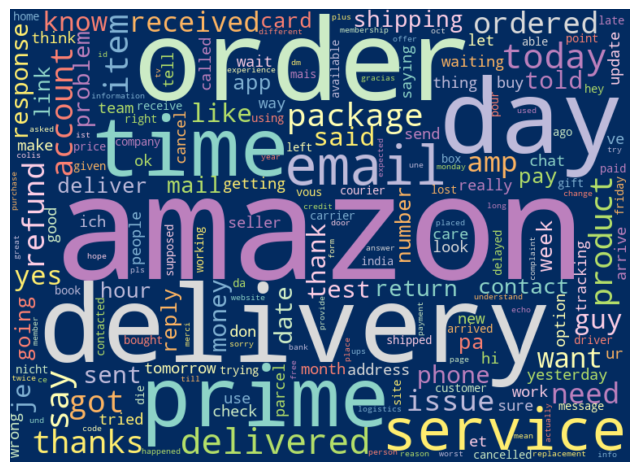

In [24]:
mydict = dict(zip(DfUniGramsAC['Word'], DfUniGramsAC['Frequency']))
word_cloud = WordCloud(width = 763, height = 557, random_state=1, background_color='#032B60', colormap='Set3', collocations=False).generate_from_frequencies(mydict)
fig=plt.figure(figsize = (8, 8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")


(-0.5, 762.5, 556.5, -0.5)

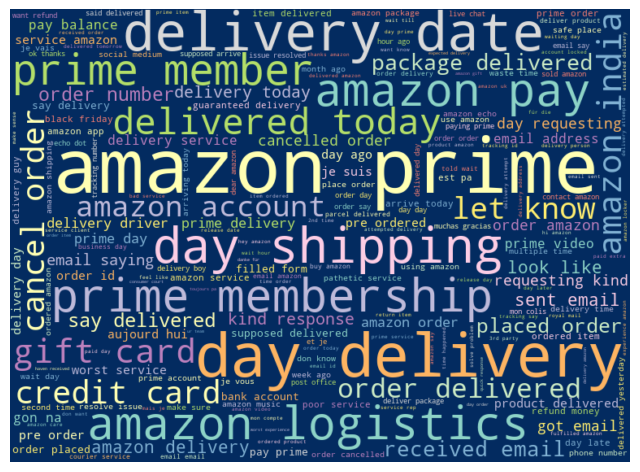

In [25]:
mydict = dict(zip(Df2GramsAC['Word'], Df2GramsAC['Frequency']))
word_cloud = WordCloud(width = 763, height = 557, random_state=1, background_color='#032B60', colormap='Set3', collocations=False).generate_from_frequencies(mydict)
fig=plt.figure(figsize = (8, 8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")

In [26]:
 def createTimeSeries(ngram,df):
        
        timeWordDF = pd.DataFrame({'Date': pd.Series(dtype='datetime64[ns]'),'Word': pd.Series(dtype='str'),'Frequency': pd.Series(dtype='int')})
        a=int(len(ngram))
        for i in range(a):
            pattern = ''r'(?:\s|^)' + ''.join(ngram["Word"].values[i]) + '(?:\s|$)'
            timetemp=pd.DataFrame().assign(Date=df[df["Lemmatized_text"].str.contains(pattern,na=False)].filter(["Date"]).astype('datetime64[ns]'), Word=ngram["Word"].values[i],Count=1)
            timeWordDF=pd.concat([timeWordDF,timetemp],ignore_index=True)            
        #timeWordDF["MeseCreazione"]=timeWordDF["DataCreazione"].apply(pd.to_datetime).dt.month.astype('Int64')
    
        
         #Creo un dataframe con le parole e Count Zero per gli ultimi 30 giorni
        end_date = '2017-11-30'
        start_date = '2017-08-01'
        
        
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        new_data = []
        for index, row in ngram.iterrows():
            parola = row['Word']
            for data in date_range:
                new_data.append([parola, data, 0])  # Count valorizzato a zero
        
        EmptyDf = pd.DataFrame(new_data, columns=['Word', 'Date', 'Count'])  
        
        
        result = pd.concat([timeWordDF, EmptyDf], axis=0)
        TimeSeries=result.groupby(['Word','Date'])["Count"].sum().reset_index().sort_values(['Word','Date'], ascending=True)
        
        #result2 = timeWordDF.append(EmptyDf_last30, ignore_index=True)
        #timeWordDFSintesi2=result2.groupby(['Parola','DataCreazione'])['Count'].sum().reset_index().sort_values(['Parola','DataCreazione'], ascending=True)
        
        return TimeSeries

In [27]:
TimeSeriesWord=createTimeSeries(DfUniGramsAC,lcdf)

In [28]:
def foundOutlierWithIsolationForest(df,contamination=0.02,soglia=10):
        df_grouped=df.groupby('Word')['Count'].max().reset_index()
        df_filtered= df_grouped[df_grouped['Count'] > soglia]
        result=pd.DataFrame({'Word': pd.Series(dtype='str'),'Date': pd.Series(dtype='datetime64[ns]'),'Count':pd.Series(dtype='int')})
        for parola in df_filtered['Word'].unique():
            # Filtra il DataFrame per SKU specifico
            word_df = df[df['Word'] == parola][[ 'Word','Date','Count']]
            # Creazione del modello Isolation Forest
            model = IsolationForest(contamination=contamination)
            # Addestramento del modello
            model.fit(word_df[['Count']] )
            # Calcola gli score di anomalia per ogni osservazione
            anomaly_scores = model.predict(word_df[['Count']])
            # Aggiungi una colonna 'IsAnomaly' al DataFrame risultante
            word_df['IsAnomaly'] = (anomaly_scores < 0).astype(int)
            result=pd.concat([result,word_df],ignore_index=True)        
        return result

In [29]:
result=foundOutlierWithIsolationForest(TimeSeriesWord)

In [36]:
TimeSeriesWord.sort_values(['Count'], ascending=False)

,Word,Date,Count
12211,amazon,2017-11-28,774.0
12213,amazon,2017-11-30,770.0
12212,amazon,2017-11-29,741.0
12214,amazon,2017-12-01,735.0
12210,amazon,2017-11-27,678.0
...,...,...,...
107561,home,2017-08-28,0.0
107562,home,2017-08-29,0.0
107563,home,2017-08-30,0.0
107564,home,2017-08-31,0.0


In [39]:
Anomaly_df=result[result['IsAnomaly']==1]

In [40]:
Anomaly_df.to_csv('AnomalyValue.csv', index=False)

In [41]:
key_word = ['fraud', 'broken', 'card', 'money', 'cancel','blocked','connect','frustrated','horrible']

In [42]:
AnomalyFiltered = result[result['Word'].isin(key_word)]

In [44]:
AnomalyFiltered=AnomalyFiltered[AnomalyFiltered['Date'].between('2017-08-01', '2017-11-30')]


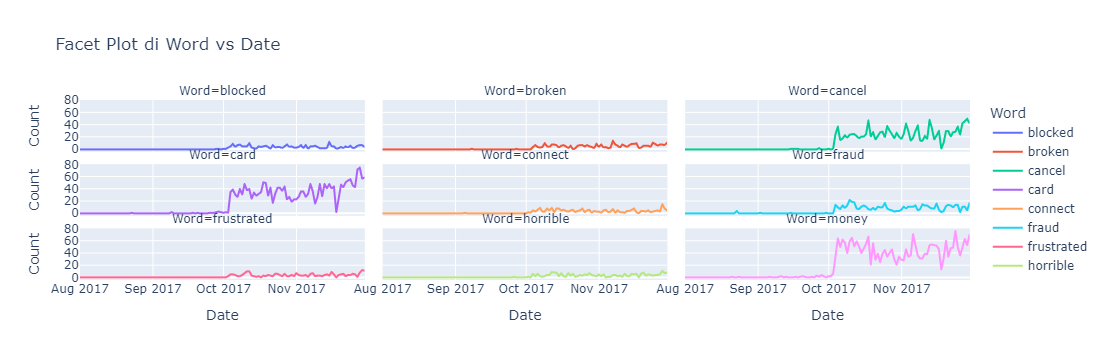

In [49]:
fig = px.line(AnomalyFiltered, x='Date', y='Count', color='Word', facet_col='Word',
                 title='Facet Plot di Word vs Date',
                 labels={'count': 'Conteggio', 'date': 'Data'},facet_col_wrap=3)

# Aggiungi l'aspetto della data sull'asse x
fig.update_xaxes(type='date')

# Visualizza il grafico
fig.show()